In [1]:
import pandas as pd
import os 
import allel
import random
import subprocess
import pickle
from os import path as op
import numpy as np
from dask import delayed
import dask.dataframe as dd
from dask import delayed, compute

In [2]:
key_files = '/carnegie/nobackup/scratch/tbellagio/gea_grene-net/key_files/'

In [3]:
pwd -P

'/carnegie/nobackup/scratch/tbellagio/gea_grene-net/baypass_lastgen'

In [25]:
flowers = pd.read_csv(key_files + 'merged_sample_table.csv')

#path_meixi = '/carnegie/data/Shared/Labs/Moi/Everyone/meixilin'

num_flowers_map = flowers.set_index('sample_name')['total_flower_counts'].to_dict()

#path_all_af_indexed = '/carnegie/nobackup/scratch/tbellagio/gea_grene-net/baypass_terminal/merged_hapFIRE_allele_frequency_indexed.csv'

#Choose SNPs for GEA structure correction in baypass

#os.listdir('/home/tbellagio/safedata/meixilin/grenenet/metadata/data')

#pd.read_csv('/home/tbellagio/safedata/ath_evo/grenephase1-data/merged_tables/merged_hapFIRE_allele_frequency_LDpruned.txt', sep = '\t')

#all_samples_af = os.listdir('/carnegie/nobackup/scratch/xwu/grenet/hapFIRE_frequencies/samples/snp_frequency/')

## the size of this file is 3235481 * 745  
#path_all_af = '/carnegie/nobackup/scratch/xwu/grenet/merged_frequency/merged_hapFIRE_allele_frequency.csv'

## path to ld prunned allele freq
#path_ldp_af = '/carnegie/nobackup/scratch/xwu/grenet/merged_frequency/merged_hapFIRE_allele_frequency_LDpruned.txt'

#first_gen = pd.read_csv(key_files + 'generation_1_sample_names.txt',header=None)[0]
#final_gen.append('0')

In [26]:
last_gen = pd.read_csv('/carnegie/nobackup/scratch/tbellagio/gea_grene-net/key_files/final_gen.csv')['sample_name']

In [6]:
#allele_freq_file = key_files + 'allele_freq_maf05_mincount05_firstgensamples.csv'

In [30]:
allele_freq_ldp = key_files + 'merged_hapFIRE_allele_frequency_LDpruned.txt'

In [31]:
# Read the file with only the specified columns in this case the final gen (355 columns)
df_ldp = dd.read_csv(allele_freq_ldp, sep = '\t', usecols = last_gen) 

In [32]:
df_shape = df_ldp.shape

In [33]:
df_shape

(Delayed('int-774f8285-4e28-4366-845f-607b78c5fdd7'), 355)

In [34]:
# The number of rows needs to be computed; the number of columns is immediate
num_rows = df_shape[0].compute()  # This computes the actual number of rows
num_columns = df_shape[1] 

In [35]:
num_rows

13985

In [36]:
num_columns

355

In [37]:
## get the vcf file frothe chromosomes and positions 

## ld pruned vcf file
ld_prunned_vcf_file = key_files + 'greneNet_final_v1.1_LDpruned.recode.vcf'
ld_prunned_vcf = allel.read_vcf(ld_prunned_vcf_file)

In [38]:
ld_prunned_chrom = ld_prunned_vcf['variants/CHROM']
ld_prunned_pos = ld_prunned_vcf['variants/POS']

In [39]:
## convert from dask to common pandas df
df_ldp = df_ldp.compute() 

In [41]:
flowers = flowers[flowers['sample_name'].isin(last_gen)]

In [42]:
flowers.head(2)

,sample_name,total_flower_counts,weighted_plot_coverage,sample_times,site,generation,plot
13,1_2_2,194,20.247160,5,1,2,2
14,1_2_3,117,6.829737,5,1,2,3


In [43]:
## generate the allale counts
num_flowers_map = flowers.set_index('sample_name')['total_flower_counts'].to_dict()

allele_counts = {}
for i in df_ldp.columns:
    num_flowers = num_flowers_map[i]
    allele_counts[i + '_minor'] = df_ldp[i] * num_flowers * 2
    maj = 1 - df_ldp[i]
    allele_counts[i + '_major'] = maj * num_flowers * 2

allele_counts = pd.concat(allele_counts,axis=1)

In [44]:
allele_counts = allele_counts.round().astype(int)

In [45]:
#allele_counts.to_csv('allele_counts_minor_major_LDP_bayapass.csv',index=None)

In [46]:
## generate the pool sizes 
#pool_sizes = {}
#for i,j in zip(allele_counts.columns[:], allele_counts.columns[1:]):
#    if i.strip('_minor') == j.strip('_major'):
#        pool_sizes[i.strip('_minor')] = (allele_counts[i][0] + allele_counts[j][0]) * 2 ## pool size = 2*#individuals

#pool_sizes = pd.concat(pool_sizes,axis=1).drop_duplicates()

In [47]:
path_analysis_neutral = '/carnegie/nobackup/scratch/tbellagio/gea_grene-net/baypass_terminal/neutral_runs_terminal_gen/'

In [48]:
path_analysis_neutral + 'allele_counts_lastgen_wheader.txt'

'/carnegie/nobackup/scratch/tbellagio/gea_grene-net/baypass_terminal/neutral_runs_terminal_gen/allele_counts_lastgen_wheader.txt'

In [49]:
# save, no need to name as 'neutral'
allele_counts.to_csv(path_analysis_neutral + 'allele_counts_lastgen_wheader.txt', sep='\t', index=False)
allele_counts.to_csv(path_analysis_neutral + 'allele_counts_lastgen_nheader.txt', sep='\t', index=False, header=False)

In [50]:
def makedir(directory: str) -> str:
    """If directory doesn't exist, create it.

    Return directory.
    """
#     if not op.exists(directory):
    os.makedirs(directory, exist_ok=True)
    
    return directory

In [51]:
### it took 11 hs to run for ~13 k snps and 60 samples, 
## now im running 13 k snps and almost 300 samples so i will give it more time 

In [53]:
path_analysis_neutral

'/carnegie/nobackup/scratch/tbellagio/gea_grene-net/baypass_terminal/neutral_runs_terminal_gen/'

In [54]:
# create sbatch files to run baypass omega estimation
# 
gfile = path_analysis_neutral + 'allele_counts_lastgen_nheader.txt'

## create a dir 
resultsdir = makedir(path_analysis_neutral + 'results/')
shdir = makedir(path_analysis_neutral + 'shfiles/')

# create sbatch files to submit on cedar server
shfiles = []
for i in range(5):
    seed = random.randint(1,100000000)
    file = shdir + 'chain_%s.sh' % str(i+1)
    cmd = f'/home/tbellagio/bin/baypass -gfile {gfile} -seed {seed} -nthreads 4 -print_omega_samples -outprefix chain_{i+1}'
    print(cmd,'\n')
    text = f'''#!/bin/bash
#SBATCH --job-name=chain_{i+1}
#SBATCH --time=2-00:00:00  # Time limit set to 4 days
#SBATCH --ntasks=1
#SBATCH --mem-per-cpu=30gb
#SBATCH --cpus-per-task=4
#SBATCH --output=chain_{i+1}_%j.out
#SBATCH --mail-user=tbellagio@carnegiescience.edu
#SBATCH --mail-type=FAIL

module load python/3.11_conda
conda activate /home/tbellagio/miniforge3/envs/run_baypass
export LD_LIBRARY_PATH="/home/tbellagio/miniforge3/envs/run_baypass/lib:$LD_LIBRARY_PATH"
cd /home/tbellagio/scratch/gea_grene-net/baypass_terminal/neutral_runs_terminal_gen
{cmd}


'''
    with open(file, 'w') as o:
        o.write("%s" % text)
    shfiles.append(file)

/home/tbellagio/bin/baypass -gfile /carnegie/nobackup/scratch/tbellagio/gea_grene-net/baypass_terminal/neutral_runs_terminal_gen/allele_counts_lastgen_nheader.txt -seed 17195732 -nthreads 4 -print_omega_samples -outprefix chain_1 

/home/tbellagio/bin/baypass -gfile /carnegie/nobackup/scratch/tbellagio/gea_grene-net/baypass_terminal/neutral_runs_terminal_gen/allele_counts_lastgen_nheader.txt -seed 71771039 -nthreads 4 -print_omega_samples -outprefix chain_2 

/home/tbellagio/bin/baypass -gfile /carnegie/nobackup/scratch/tbellagio/gea_grene-net/baypass_terminal/neutral_runs_terminal_gen/allele_counts_lastgen_nheader.txt -seed 5823836 -nthreads 4 -print_omega_samples -outprefix chain_3 

/home/tbellagio/bin/baypass -gfile /carnegie/nobackup/scratch/tbellagio/gea_grene-net/baypass_terminal/neutral_runs_terminal_gen/allele_counts_lastgen_nheader.txt -seed 62794173 -nthreads 4 -print_omega_samples -outprefix chain_4 

/home/tbellagio/bin/baypass -gfile /carnegie/nobackup/scratch/tbellagio/g

In [56]:
## now run the shfiles
for shfile in shfiles:
    # Submit each sbatch script to the SLURM scheduler
    subprocess.run(["sbatch", shfile], check=True)

Submitted batch job 30532
Submitted batch job 30533
Submitted batch job 30534
Submitted batch job 30535
Submitted batch job 30536


In [ ]:
rsync -av --include '*/' --exclude 'results/' /home/tbellagio/scratch/gea_grene-net/baypass_terminal tbellg@hpc.brc.berkeley.edu:/global/scratch/users/tbellg/gea_grene-net/

In [ ]:
### create files for savio 

In [32]:
# create sbatch files to run baypass omega estimation
path_analysis = '/global/scratch/users/tbellg/gea_grene-net/baypass_terminal/'
path_analysis_calc = '/carnegie/nobackup/scratch/tbellagio/gea_grene-net/baypass_terminal/'
# 
gfile = path_analysis + 'allele_counts_3rdgen_nheader.txt'
#poolsizefile = path_analysis + 'pool_sizes_3rdgen_nheader.txt'

In [23]:
# create sbatch files to run baypass omega estimation
path_analysis_calc = '/carnegie/nobackup/scratch/tbellagio/gea_grene-net/baypass_terminal/'
# 
gfile = path_analysis + 'allele_counts_3rdgen_nheader.txt'
poolsizefile = path_analysis + 'pool_sizes_3rdgen_nheader.txt'

## create a dir 
resultsdir = makedir(path_analysis_calc + 'neutral_runs/results/')
shdir = makedir(path_analysis_calc + 'neutral_runs/shfiles_caltech/')

# create sbatch files to submit on cedar server
shfiles = []
for i in range(5):
    seed = random.randint(1,100000000)
    file = shdir + 'chain_%s.sh' % str(i+1)
    cmd = f'/home/tbellagi/bin/baypass -gfile {gfile} -poolsizefile {poolsizefile} \
-nthreads 8 -seed {seed} -print_omega_samples -outprefix chain_{i+1}'
    print(cmd,'\n')
    text = f'''#!/bin/bash
#SBATCH --job-name=chain_{i+1}
#SBATCH --time=5-00:00:00
#SBATCH --nodes=1
#SBATCH --ntasks=1
#SBATCH --mem-per-cpu=40gb
#SBATCH --cpus-per-task=10
#SBATCH --output=chain_{i+1}_%j.out
#SBATCH --mail-user=tbellagio@carnegiescience.edu
#SBATCH --mail-type=FAIL

cd /home/tbellagi/bigscratch/gea/baypass_terminal
{cmd}


'''
    with open(file, 'w') as o:
        o.write("%s" % text)
    shfiles.append(file)

/home/tbellagi/bin/baypass -gfile /home/tbellagi/bigscratch/gea/baypass_terminal/allele_counts_3rdgen_nheader.txt -poolsizefile /home/tbellagi/bigscratch/gea/baypass_terminal/pool_sizes_3rdgen_nheader.txt -nthreads 8 -seed 32042421 -print_omega_samples -outprefix chain_1 

/home/tbellagi/bin/baypass -gfile /home/tbellagi/bigscratch/gea/baypass_terminal/allele_counts_3rdgen_nheader.txt -poolsizefile /home/tbellagi/bigscratch/gea/baypass_terminal/pool_sizes_3rdgen_nheader.txt -nthreads 8 -seed 49531644 -print_omega_samples -outprefix chain_2 

/home/tbellagi/bin/baypass -gfile /home/tbellagi/bigscratch/gea/baypass_terminal/allele_counts_3rdgen_nheader.txt -poolsizefile /home/tbellagi/bigscratch/gea/baypass_terminal/pool_sizes_3rdgen_nheader.txt -nthreads 8 -seed 25839429 -print_omega_samples -outprefix chain_3 

/home/tbellagi/bin/baypass -gfile /home/tbellagi/bigscratch/gea/baypass_terminal/allele_counts_3rdgen_nheader.txt -poolsizefile /home/tbellagi/bigscratch/gea/baypass_terminal/poo

In [20]:
## now run the shfiles
for shfile in shfiles:
    # Submit each sbatch script to the SLURM scheduler
    subprocess.run(["sbatch", shfile], check=True)

Submitted batch job 324
Submitted batch job 325
Submitted batch job 326
Submitted batch job 327
Submitted batch job 328


In [122]:
### create env file 

In [33]:
path_analysis = '/carnegie/nobackup/scratch/tbellagio/gea_grene-net/baypass_terminal/'

In [34]:
#finalgen_samples = pd.read_csv(key_files + 'final_gen.csv')['sample_name']

In [35]:
#finalgen_samples = pd.read_csv('../final_gen.csv')['sample_name']
first_gen_samples = pd.read_csv('../key_files/generation_1_sample_names.txt',header=None)[0]

samples = first_gen_samples.to_list()

#clim_sites_during_exp = pd.read_csv('/carnegie/nobackup/scratch/tbellagio/grene/data/bioclimvars_experimental_sites_era5.csv')
clim_sites_during_exp = pd.read_csv('../key_files/bioclimvars_sites_era5_year_2018.csv')

sites_af = pd.Series(samples).str.split('_').str[0].astype(int)

sites_af.name = 'site'

env = sites_af.reset_index().merge(clim_sites_during_exp).drop(['index'],axis=1)

In [36]:
sites = env[['site', 'bio1', 'bio17']]

In [37]:
#pca_clim_sites_during_exp = pd.read_csv('/carnegie/nobackup/scratch/tbellagio/gea_grene-net/pca_climate_var_experimental_sites.csv').drop('Unnamed: 0',axis=1)

In [38]:
#clim = pd.merge(clim_sites_during_exp, pca_clim_sites_during_exp)

In [39]:
## for now im gonna run the analysis on bio1, bio12 and  and the 2 first components of the pca 

In [40]:
sites = sites.set_index('site')

In [41]:
## save the environmental var names 
import pickle

# Some data to pickle
env_vars_names = sites.columns.tolist()
# Pickle the data into a file
with open(path_analysis + 'env_vars_names', 'wb') as f:
    pickle.dump(env_vars_names, f)

In [42]:
from sklearn.preprocessing import StandardScaler

In [43]:
# Standardize the data
scaler = StandardScaler()
sites_scaled = scaler.fit_transform(sites)

In [44]:
env = pd.DataFrame(data=sites_scaled, index = sites.index).T

In [45]:
env

site,1,1,1,1,1,1,1,1,1,1,...,60,60,60,60,60,60,60,60,60,60
0,-0.795347,-0.795347,-0.795347,-0.795347,-0.795347,-0.795347,-0.795347,-0.795347,-0.795347,-0.795347,...,1.343429,1.343429,1.343429,1.343429,1.343429,1.343429,1.343429,1.343429,1.343429,1.343429
1,-0.189220,-0.189220,-0.189220,-0.189220,-0.189220,-0.189220,-0.189220,-0.189220,-0.189220,-0.189220,...,-1.383041,-1.383041,-1.383041,-1.383041,-1.383041,-1.383041,-1.383041,-1.383041,-1.383041,-1.383041


In [46]:
# save
# save, no need to name as 'neutral'
env.to_csv(path_analysis + 'env_firstgen_wheader.txt', sep='\t', index=False)
env.to_csv(path_analysis + 'env_firstgen_nheader.txt', sep='\t', index=False, header=False)

In [145]:
### now create the gfile fro the whole run 

In [7]:
path_analysis = '/carnegie/nobackup/scratch/tbellagio/gea_grene-net/baypass_lastgen/'

In [8]:
gfiles_path = os.path.join(path_analysis, 'individual_gfiles_last_gen')
os.makedirs(gfiles_path, exist_ok=True)

In [9]:
def generate_allele_counts(partition, num_flowers_map, first_gen):
    ## adjust the order so that all files have the same ########################
    partition = partition[first_gen]
    ## adjust the order ########################
    
    ## check the order 
    #if (partition.columns == first_gen).all():
    #    print('correct order 1')
    #else:
    #    print('wrong order 1')
    ## process all the columns but the index
    index_to_save = partition['0']
    partition = partition.drop('0',axis=1)
    
    allele_counts = {}
    #print(partition.columns)
    for column in partition.columns:
        num_flowers = num_flowers_map.get(column, 0)  # Default to 0 if not found
        allele_counts[column + '_minor'] = partition[column] * num_flowers * 2
        allele_counts[column + '_major'] = (1 - partition[column]) * num_flowers * 2
    # Explicitly convert to DataFrame
    result_df = pd.DataFrame(allele_counts).round().astype(int)
    result_df['positions'] = index_to_save
    
    ## check the order 

    #if (result_df.columns == correct_order).all():
    #    print('correct order')
    #else:
    #    print('wrong order')
    return result_df

In [10]:
def save_partition(partition, partition_index, gfiles_path):
    print(len(partition))
    filename = f"{gfiles_path}/partition_{partition_index}.txt"
    ## save the index and the data separetly 
    index_to_save = partition['positions']
    partition = partition.drop('positions',axis=1)
    # Save DataFrame with index
    partition.to_csv(filename, index=False, header=False)  # Include the index when saving
    
    ## just in case save also de columns names 
    column_names = partition.columns  # Extract the index list
    with open(gfiles_path + f'/column_names_partition_{partition_index}', 'wb') as f:
        pickle.dump(column_names, f)
    
    loci_list = index_to_save.tolist()  # Extract the index list
    with open(gfiles_path + f'/loci_partition_{partition_index}', 'wb') as f:
        pickle.dump(loci_list, f)
        
    return filename

In [11]:
key_files

'/carnegie/nobackup/scratch/tbellagio/gea_grene-net/key_files/'

In [ ]:
'/carnegie/nobackup/scratch/tbellagio/gea_grene-net/key_files/allele_freq_maf05_mincount05_lastgensamples.csv'

In [12]:
last_gen = pd.read_csv('/carnegie/nobackup/scratch/tbellagio/gea_grene-net/key_files/final_gen.csv')['sample_name']
allele_freq_file = key_files + 'allele_freq_maf05_mincount05_lastgensamples.csv'

In [ ]:
#pd.read_csv('baypass_allele_counts_drop_duplicates_terminal_gen')

In [ ]:
#af = dd.read_csv(key_files + 'merged_hapFIRE_allele_frequency.txt', sep = '\t', usecols = first_gen)

#af = af.compute()

#af = af.reset_index(drop=True)

#snp_dict = pd.read_csv(key_files + 'var_pos_grenenet.csv')

#mask = snp_dict['total_alleles05filter'].notna()

#af = af[mask]

#af.to_csv(key_files + 'allele_freq_maf05_mincount05_firstgensamples.csv', index=None)

In [13]:
gfile_ddf = dd.read_csv(allele_freq_file)
af = gfile_ddf.compute()

In [14]:
snps_dict = pd.read_csv(key_files +  'var_pos_grenenet.csv')

In [15]:
snps_dict

,id,pos,chrom,maf05filter,total_alleles05filter_firstgen,total_alleles05filter_lastgen
0,1_291,291,1,NaN,NaN,NaN
1,1_346,346,1,1_346,1_346,1_346
2,1_349,349,1,NaN,NaN,NaN
3,1_352,352,1,NaN,NaN,NaN
4,1_353,353,1,1_353,1_353,1_353
...,...,...,...,...,...,...
3235475,5_26975208,26975208,5,NaN,NaN,NaN
3235476,5_26975215,26975215,5,NaN,NaN,NaN
3235477,5_26975267,26975267,5,NaN,NaN,NaN
3235478,5_26975272,26975272,5,5_26975272,5_26975272,5_26975272


In [16]:
snps_dict = snps_dict[snps_dict['total_alleles05filter_lastgen'].notna()].reset_index(drop=True)

In [17]:
af = af.reset_index(drop=True)

In [18]:
af

,1_2_2,1_2_3,1_3_1,1_3_4,1_3_5,1_3_6,1_3_7,1_3_8,1_3_9,1_3_10,...,60_1_3,60_1_4,60_1_5,60_1_6,60_1_7,60_1_8,60_1_9,60_1_10,60_1_11,60_1_12
0,0.341474,0.327235,0.746828,0.616446,0.349114,0.379077,0.091375,0.537846,0.098916,0.195311,...,0.267541,0.216716,0.423299,0.403407,0.446614,0.233017,0.658456,0.239321,0.478471,0.596091
1,0.054013,0.020423,0.006074,0.001199,0.178328,0.122217,0.008013,0.098583,0.120582,0.002295,...,0.042362,0.173450,0.027055,0.003218,0.017458,0.135612,0.016264,0.009464,0.085654,0.012627
2,0.123593,0.050841,0.062592,0.002276,0.125150,0.008275,0.594746,0.008767,0.023503,0.004233,...,0.038804,0.007692,0.006626,0.133387,0.017367,0.226834,0.011577,0.021688,0.096677,0.017196
3,0.011205,0.076021,0.002047,0.031933,0.085963,0.003120,0.009441,0.025593,0.043369,0.002041,...,0.097181,0.049337,0.127186,0.003473,0.004584,0.136237,0.051577,0.193522,0.183210,0.110149
4,0.011205,0.076021,0.002047,0.031933,0.085963,0.003120,0.009441,0.025593,0.043369,0.002041,...,0.097181,0.049337,0.127186,0.003473,0.004584,0.136237,0.051577,0.193522,0.183210,0.110149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048630,0.917028,0.919834,0.977146,0.908383,0.841736,0.977977,0.523653,0.988422,0.883346,0.994757,...,0.883648,0.717857,0.859736,0.886866,0.982348,0.899583,0.710942,0.784726,0.697580,0.816260
1048631,0.135335,0.028683,0.125749,0.001332,0.230004,0.191362,0.018391,0.146211,0.180197,0.177818,...,0.153699,0.229038,0.027140,0.139404,0.005478,0.057943,0.007707,0.093007,0.091761,0.009283
1048632,0.135335,0.028683,0.125749,0.001332,0.230004,0.191362,0.018391,0.146211,0.180197,0.177818,...,0.153699,0.229038,0.027140,0.139404,0.005478,0.057943,0.007707,0.093007,0.091761,0.009283
1048633,0.497660,0.391916,0.782058,0.358331,0.671701,0.472690,0.403074,0.767245,0.601810,0.401191,...,0.694874,0.304171,0.486650,0.180774,0.449133,0.749842,0.311343,0.363201,0.550693,0.353722


In [19]:
af[0] = snps_dict['id']

In [20]:
af.to_csv(key_files + 'allele_freq_maf05_mincount05_lastgensamples_windexsnpid.csv',index=None)

In [21]:
af

,1_2_2,1_2_3,1_3_1,1_3_4,1_3_5,1_3_6,1_3_7,1_3_8,1_3_9,1_3_10,...,60_1_4,60_1_5,60_1_6,60_1_7,60_1_8,60_1_9,60_1_10,60_1_11,60_1_12,0
0,0.341474,0.327235,0.746828,0.616446,0.349114,0.379077,0.091375,0.537846,0.098916,0.195311,...,0.216716,0.423299,0.403407,0.446614,0.233017,0.658456,0.239321,0.478471,0.596091,1_346
1,0.054013,0.020423,0.006074,0.001199,0.178328,0.122217,0.008013,0.098583,0.120582,0.002295,...,0.173450,0.027055,0.003218,0.017458,0.135612,0.016264,0.009464,0.085654,0.012627,1_353
2,0.123593,0.050841,0.062592,0.002276,0.125150,0.008275,0.594746,0.008767,0.023503,0.004233,...,0.007692,0.006626,0.133387,0.017367,0.226834,0.011577,0.021688,0.096677,0.017196,1_363
3,0.011205,0.076021,0.002047,0.031933,0.085963,0.003120,0.009441,0.025593,0.043369,0.002041,...,0.049337,0.127186,0.003473,0.004584,0.136237,0.051577,0.193522,0.183210,0.110149,1_395
4,0.011205,0.076021,0.002047,0.031933,0.085963,0.003120,0.009441,0.025593,0.043369,0.002041,...,0.049337,0.127186,0.003473,0.004584,0.136237,0.051577,0.193522,0.183210,0.110149,1_396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048630,0.917028,0.919834,0.977146,0.908383,0.841736,0.977977,0.523653,0.988422,0.883346,0.994757,...,0.717857,0.859736,0.886866,0.982348,0.899583,0.710942,0.784726,0.697580,0.816260,5_26975078
1048631,0.135335,0.028683,0.125749,0.001332,0.230004,0.191362,0.018391,0.146211,0.180197,0.177818,...,0.229038,0.027140,0.139404,0.005478,0.057943,0.007707,0.093007,0.091761,0.009283,5_26975121
1048632,0.135335,0.028683,0.125749,0.001332,0.230004,0.191362,0.018391,0.146211,0.180197,0.177818,...,0.229038,0.027140,0.139404,0.005478,0.057943,0.007707,0.093007,0.091761,0.009283,5_26975148
1048633,0.497660,0.391916,0.782058,0.358331,0.671701,0.472690,0.403074,0.767245,0.601810,0.401191,...,0.304171,0.486650,0.180774,0.449133,0.749842,0.311343,0.363201,0.550693,0.353722,5_26975272


In [22]:
allele_freq_file_w_index = key_files + 'allele_freq_maf05_mincount05_lastgensamples_windexsnpid.csv'

In [23]:
# Load the data
## make 40MB partitions so that aprox 3500 snps
gfile_ddf = dd.read_csv(allele_freq_file_w_index, blocksize='25MB')
# Now repartition if necessary
#gfile_ddf = gfile_ddf.repartition(npartitions=900)

In [29]:
last_gen = pd.read_csv('../key_files/final_gen.csv')['sample_name']
last_gen = last_gen.to_list()
last_gen.append('0')

In [31]:
# dont need it for now 
processed_partitions = gfile_ddf.map_partitions(generate_allele_counts, num_flowers_map, last_gen)

save_tasks = [delayed(save_partition)(processed_partitions.get_partition(i), i, gfiles_path)
          for i in range(processed_partitions.npartitions)]

In [38]:
#save_tasks = [delayed(save_partition)(gfile_ddf.get_partition(i), i, gfiles_path)
#          for i in range(gfile_ddf.npartitions)]

In [32]:
len(save_tasks)

210

In [120]:
140 * 5259

736260

In [117]:
## used for checking 
#save_tasks = [delayed(save_partition)(processed_partitions.get_partition(i), i, gfiles_path)
#          for i in range(5)]

In [33]:
# Compute all tasks
results = compute(*save_tasks)

4999
4989
4978
4991
49974980

49834997

4991
4991
4997
4991
4999
4984
5001
4989
5006
4986
4991
5028
4992
5008
4986
4995
4997
4979
4975
4991
4991
4980
5007
4999
4993
4988
4981
5001
5011
5018
4986
5005
4981
5000
5000
4985
4993
4991
4986
4991
4993
4993
4987
5003
5012
5000
5009
5004
4983
5004
4989
5000
4994
4978
4992
4995
4988
5007
4996
4984
5008
5013
4981
5015
4982
4994
5007
4986
4988
5003
4989
4958
4997
4993
4986
5000
5000
4976
4992
4987
5010
4992
4971
5000
4990
4997
5002
4986
4992
4993
4983
4981
5000
4979
4995
5000
4970
5000
5007
4976
5016
4990
4990
5009
4989
4995
5000
4985
4984
4987
4981
5000
4995
5000
4972
4997
4996
4985
5002
4991
5026
4995
5003
4999
5011
4988
4989
4985
4993
4994
5001
4995
4994
4999
4990
5001
4989
4995
4998
4987
4983
5000
5001
4998
5001
4980
4982
5002
4998
4988
5010
4991
4982
5003
4992
4989
5005
4995
4994
4998
4990
4997
4995
4991
4968
4998
5011
4982
5010
4993
4987
5006
4985
4979
5000
4989
4995
4998
4978
4998
5008
5010
4987
5003
4999
4986
4984
5000
4991
4975
4988
4984


In [165]:
## after this there should be 1700 * 3 files in the folder including gfiles, snpspositions and column names 

In [34]:
data_all = []
for i in range(gfile_ddf.npartitions):
    pickle_file_path = gfiles_path + f'/loci_partition_{i}'
    with open(pickle_file_path, 'rb') as file:
        data = pickle.load(file)
        data_all.append(data)

In [35]:
from itertools import chain

# Flatten the list of lists
flat_list = list(chain.from_iterable(data_all))

# Convert the flattened list to a set and compare lengths to check for duplicates
unique_data = set(flat_list)
if len(unique_data) != len(flat_list):
    print("There are repeated values")
else:
    print("All values are unique")

All values are unique


In [59]:
gfile_dir = '/carnegie/nobackup/scratch/tbellagio/gea_grene-net/baypass_terminal/individual_gfiles/'

path_analysis = '/carnegie/nobackup/scratch/tbellagio/gea_grene-net/baypass_terminal/'

# get gfiles
gfiles = [gfile_dir + i for i in os.listdir(gfile_dir) if '.txt' in i]

In [60]:
partition_214 = pd.read_csv(gfiles[0],header=None)

In [61]:
part = gfiles[0].split('/')[-1]

In [62]:
pickle_file_path = gfiles_path + f'/column_names_' + part.replace('.txt','')
with open(pickle_file_path, 'rb') as file:
    data214_columns = pickle.load(file)

In [63]:
pickle_file_path = gfiles_path + f'/loci_partition_0'
with open(pickle_file_path, 'rb') as file:
    data214 = pickle.load(file)

In [64]:
partition_214.columns = data214_columns

In [65]:
minor_cols = [i for i in partition_214.columns if 'minor' in i]

In [66]:
partition_214 = partition_214[minor_cols]

In [67]:
pos_column = pd.read_csv(path_analysis + 'index_to_add.csv')

In [68]:
## making sure all the positions are present
are_equal = set(pos_column['0']) == unique_data
print(are_equal)

False


In [69]:
partition_214 = pd.read_csv(path_analysis + 'individual_gfiles/partition_0.txt',header=None)

In [70]:
#os.listdir(path_analysis + 'individual_gfiles/')

In [123]:
pickle_file_path = gfiles_path + f'/loci_partition_0'
with open(pickle_file_path, 'rb') as file:
    data214 = pickle.load(file)

In [72]:
pickle_file_path = gfiles_path + f'/column_names_partition_0'
with open(pickle_file_path, 'rb') as file:
    data214_columns = pickle.load(file)

In [73]:
partition_214.columns = data214_columns

In [74]:
partition_214.index = data214

In [75]:
partition_214

,1_2_2_minor,1_2_2_major,1_2_3_minor,1_2_3_major,1_3_1_minor,1_3_1_major,1_3_4_minor,1_3_4_major,1_3_5_minor,1_3_5_major,...,60_1_8_minor,60_1_8_major,60_1_9_minor,60_1_9_major,60_1_10_minor,60_1_10_major,60_1_11_minor,60_1_11_major,60_1_12_minor,60_1_12_major
1_291,2,192,9,108,0,24,1,19,6,66,...,1,23,0,7,3,18,4,16,2,18
1_346,66,128,38,79,18,6,12,8,25,47,...,6,18,5,2,5,16,10,10,12,8
1_349,0,194,0,117,0,24,0,20,0,72,...,0,24,0,7,0,21,0,20,0,20
1_352,22,172,4,113,3,21,0,20,0,72,...,0,24,0,7,0,21,0,20,0,20
1_353,10,184,2,115,0,24,0,20,13,59,...,3,21,0,7,0,21,2,18,0,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1_521501,19,175,19,98,1,23,0,20,1,71,...,0,24,1,6,0,21,0,20,0,20
1_521618,144,50,103,14,21,3,14,6,67,5,...,22,2,7,0,20,1,19,1,18,2
1_521635,40,154,46,71,16,8,2,18,11,61,...,9,15,4,3,8,13,3,17,3,17
1_521649,5,189,4,113,0,24,0,20,8,64,...,4,20,0,7,3,18,0,20,2,18


In [76]:
minor_cols = [i for i in partition_214.columns if 'minor' in i]

In [77]:
partition_214 = partition_214[minor_cols]

In [78]:
partition_214.sum(axis=1)[partition_214.sum(axis=1) == 0]

Series([], dtype: int64)

In [79]:
rs = (partition_214 != 0).sum(axis=1)

In [80]:
rs[rs == 0 ]

Series([], dtype: int64)

In [ ]:
partition_214['pos'] = data214

In [99]:
check = pd.read_csv(allele_counts, nrows = 5493)

In [101]:
#check = check[final_gen]

In [102]:
#check.columns = columns_for.columns 

In [103]:
#check = generate_allele_counts(check, num_flowers_map, final_gen)

In [96]:
check = check.set_index('positions')

In [90]:
partition_214 = partition_214.set_index('pos')

KeyError: "None of ['pos'] are in the columns"

In [105]:
check

,id,1_2_2_minor,1_2_2_major,1_2_3_minor,1_2_3_major,1_3_1_minor,1_3_1_major,1_3_4_minor,1_3_4_major,1_3_5_minor,...,60_1_8_minor,60_1_8_major,60_1_9_minor,60_1_9_major,60_1_10_minor,60_1_10_major,60_1_11_minor,60_1_11_major,60_1_12_minor,60_1_12_major
0,1_291,2,192,9,108,0,24,1,19,6,...,1,23,0,7,3,18,4,16,2,18
1,1_346,66,128,38,79,18,6,12,8,25,...,6,18,5,2,5,16,10,10,12,8
2,1_349,0,194,0,117,0,24,0,20,0,...,0,24,0,7,0,21,0,20,0,20
3,1_352,22,172,4,113,3,21,0,20,0,...,0,24,0,7,0,21,0,20,0,20
4,1_353,10,184,2,115,0,24,0,20,13,...,3,21,0,7,0,21,2,18,0,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5488,1_521501,19,175,19,98,1,23,0,20,1,...,0,24,1,6,0,21,0,20,0,20
5489,1_521618,144,50,103,14,21,3,14,6,67,...,22,2,7,0,20,1,19,1,18,2
5490,1_521635,40,154,46,71,16,8,2,18,11,...,9,15,4,3,8,13,3,17,3,17
5491,1_521649,5,189,4,113,0,24,0,20,8,...,4,20,0,7,3,18,0,20,2,18


In [106]:
partition_214

,1_2_2_minor,1_2_3_minor,1_3_1_minor,1_3_4_minor,1_3_5_minor,1_3_6_minor,1_3_7_minor,1_3_8_minor,1_3_9_minor,1_3_10_minor,...,60_1_3_minor,60_1_4_minor,60_1_5_minor,60_1_6_minor,60_1_7_minor,60_1_8_minor,60_1_9_minor,60_1_10_minor,60_1_11_minor,60_1_12_minor
1_291,2,9,0,1,6,0,1,0,1,0,...,2,0,1,0,0,1,0,3,4,2
1_346,66,38,18,12,25,17,11,4,2,1,...,5,4,7,6,5,6,5,5,10,12
1_349,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1_352,22,4,3,0,0,3,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1_353,10,2,0,0,13,5,1,1,3,0,...,1,3,0,0,0,3,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1_521501,19,19,1,0,1,0,1,1,1,0,...,0,0,0,0,0,0,1,0,0,0
1_521618,144,103,21,14,67,35,98,6,18,4,...,19,19,15,16,11,22,7,20,19,18
1_521635,40,46,16,2,11,18,65,4,5,2,...,9,4,1,7,5,9,4,8,3,3
1_521649,5,4,0,0,8,0,1,0,6,1,...,3,0,5,0,0,4,0,3,0,2


In [62]:
(partition_214 == check).all().all()

True

In [125]:
from typing import Optional, Union

In [126]:
def read(file: str, lines=True, ignore_blank=False) -> Union[str, list]:
    """Read lines from a file.

    Return a list of lines, or one large string
    """
    with open(file, "r") as o:
        text = o.read()

    if lines is True:
        text = text.split("\n")
        if ignore_blank is True:
            text = [line for line in text if line != ""]

    return text

In [18]:
## check omegas for convergence 

In [5]:
path_analysis = '/carnegie/nobackup/scratch/tbellagio/gea_grene-net/baypass_terminal/neutral_runs/'

In [6]:
files = os.listdir(path_analysis)

In [7]:
result_files = [i for i in files if 'mat_omega' in i]

In [8]:
result_files

['chain_2_mat_omega.out',
 'chain_5_mat_omega.out',
 'chain_1_mat_omega.out',
 'chain_4_mat_omega.out',
 'chain_3_mat_omega.out']

In [9]:
filename = 'chain_3_mat_omega.out'
with open(path_analysis + filename, 'r') as file:
    content = file.read()

In [10]:
def read(filename):
    """Read the file and return a list of its lines."""
    with open(filename, 'r') as file:
        return file.readlines()

In [11]:
# get a list of values by vectorizing the matrix for each chain
matrices = {}
for m in result_files:
    chain = op.basename(m).split("_mat")[0]
    text = read(path_analysis + m)
    rows = []
    for line in text:
        rows.extend([float(val) for val in line.split()])
    matrices[chain] = rows
len(matrices[chain])

106276

In [12]:
np.sqrt(len(matrices[chain]))  # num pops

326.0

In [13]:
from scipy.stats import pearsonr

In [14]:
# look at pairwise correlations among chains
for i,chaini in enumerate(matrices):
    for j,chainj in enumerate(matrices):
        if i < j:
            print(chaini,chainj,pearsonr(matrices[chaini], matrices[chainj]))

chain_2 chain_5 (0.9803987102520908, 0.0)
chain_2 chain_1 (0.9871101259075103, 0.0)
chain_2 chain_4 (0.9864837563438007, 0.0)
chain_2 chain_3 (0.9853376650357154, 0.0)
chain_5 chain_1 (0.9908278892508438, 0.0)
chain_5 chain_4 (0.9889468657291608, 0.0)
chain_5 chain_3 (0.9848562986053842, 0.0)
chain_1 chain_4 (0.992059150571879, 0.0)
chain_1 chain_3 (0.9877924188030387, 0.0)
chain_4 chain_3 (0.9901117840718706, 0.0)


chain_2 chain_5 1.0461082859012616 -2.2115689307117483


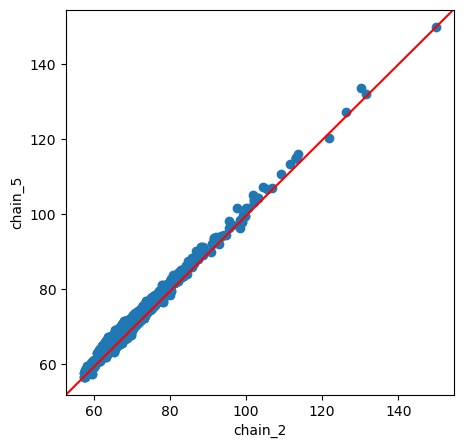

chain_2 chain_1 1.0526132766590346 -3.3009250205678944


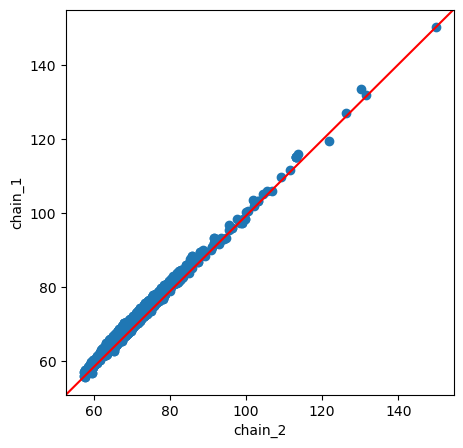

chain_2 chain_4 1.0274870143327162 -2.227805300680249


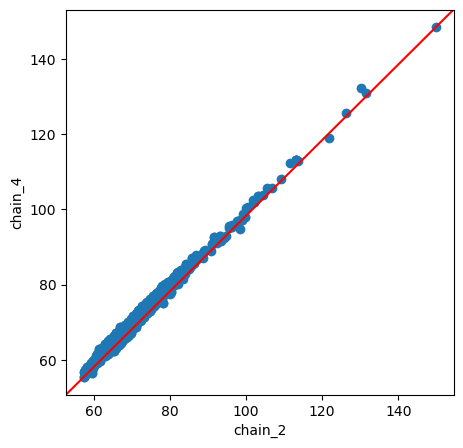

chain_2 chain_3 1.0585288991354842 -3.9176108464942723


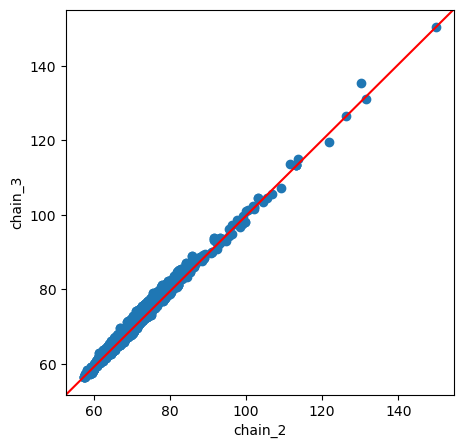

chain_5 chain_1 0.9902105476553495 0.02659611273003653


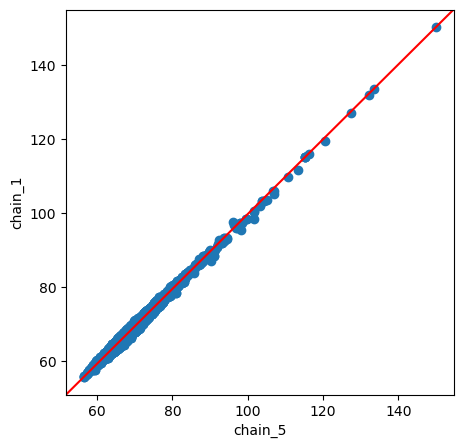

chain_5 chain_4 0.9653514450217878 1.1044552310477564


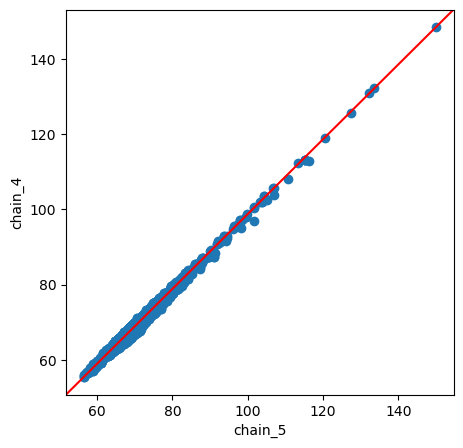

chain_5 chain_3 0.9915545027448225 -0.2807577033502312


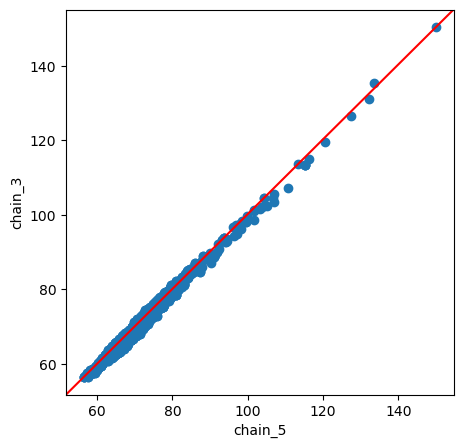

chain_1 chain_4 0.9689932107886243 1.4810780991324952


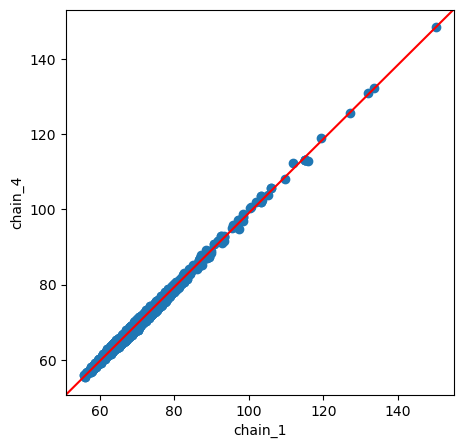

chain_1 chain_3 0.9951306145173578 0.11730836223234942


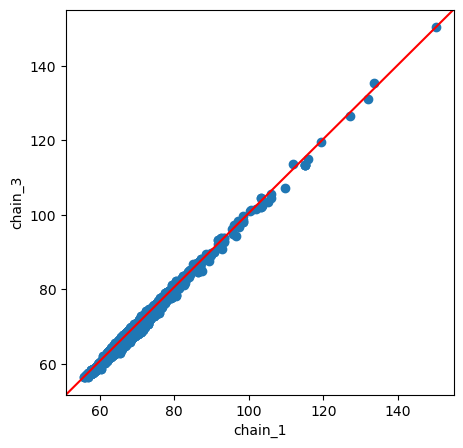

chain_4 chain_3 1.0212109456913565 -1.0143084289768007


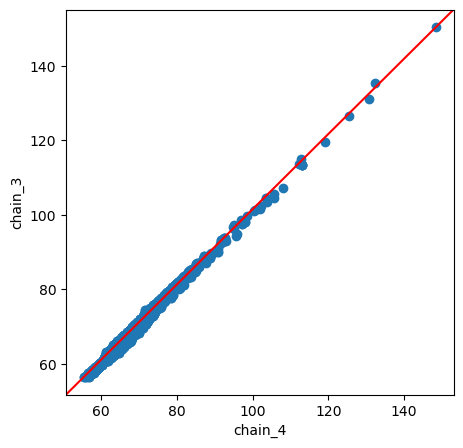

In [15]:
# plot pairwise chains agains 1:1 line, print slope and intercept from data
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

for i,chaini in enumerate(matrices):
    for j,chainj in enumerate(matrices):
        if i < j:
            slope, intercept = np.polyfit(matrices[chaini], matrices[chainj], 1)
            print(chaini, chainj, slope, intercept)
            fig, ax = plt.subplots(figsize=(5,5))
            ax.scatter(matrices[chaini], matrices[chainj])
            ax.set_xlabel(chaini)
            ax.set_ylabel(chainj)
            line = mlines.Line2D([0, 1], [0, 1], color='red')
            transform = ax.transAxes
            line.set_transform(transform)
            ax.add_line(line)           
            
            plt.show()


In [16]:
result_files.sort()

In [17]:
result_files

['chain_1_mat_omega.out',
 'chain_2_mat_omega.out',
 'chain_3_mat_omega.out',
 'chain_4_mat_omega.out',
 'chain_5_mat_omega.out']

In [18]:
# make a matrix with the average across matrices
mats = {}
for m in result_files:
    chain = op.basename(m).split("_mat")[0]
    mats[chain] = pd.read_table(path_analysis + m, delim_whitespace=True, header=None)
mats[chain].head()

,0,1,2,3,4,5,6,7,8,9,...,316,317,318,319,320,321,322,323,324,325
0,70.801851,68.460159,69.331527,69.626122,68.575476,69.728896,68.574496,69.304232,69.294399,69.431929,...,69.110427,70.366992,69.880590,71.784053,72.707035,68.690618,69.778267,70.416917,69.562432,68.250577
1,68.460159,67.831461,67.911831,68.165601,67.445267,68.330766,67.466432,67.944218,67.859836,68.161169,...,67.833347,69.035441,67.907912,69.557332,70.296503,67.396249,68.427947,69.100264,67.859966,67.266673
2,69.331527,67.911831,69.186360,68.864447,67.894367,68.970391,67.999969,68.618492,68.639828,68.666603,...,68.579453,69.608751,68.886198,70.419965,71.487931,68.189177,69.397928,69.425710,68.518081,67.542052
3,69.626122,68.165601,68.864447,69.758958,68.255251,69.241518,68.221407,69.069878,69.085110,69.155572,...,68.927465,70.559958,69.467434,71.117370,71.459135,68.565182,69.587661,70.311163,69.477475,68.026047
4,68.575476,67.445267,67.894367,68.255251,68.519309,68.437438,67.738719,68.342908,68.112856,68.417024,...,68.703470,68.878311,69.297567,70.093171,70.116347,67.850432,69.063899,69.836651,68.456463,68.005870


In [19]:
mats.keys()

dict_keys(['chain_1', 'chain_2', 'chain_3', 'chain_4', 'chain_5'])

In [20]:
# sum across each matrix (to use in average calc below)
for chain,m in mats.items():
    print(chain)
    if chain == 'chain_1':
        summatrix = np.array(m)
    else:
        summatrix = summatrix + np.array(m)
summatrix

chain_1
chain_2
chain_3
chain_4
chain_5


array([[350.414311, 338.481962, 343.077449, ..., 347.076766, 343.739936,
        337.856084],
       [338.481962, 334.971528, 335.676593, ..., 340.169118, 335.037215,
        332.596969],
       [343.077449, 335.676593, 342.346099, ..., 342.092433, 338.568286,
        334.186438],
       ...,
       [347.076766, 340.169118, 342.092433, ..., 391.357275, 358.127101,
        346.945921],
       [343.739936, 335.037215, 338.568286, ..., 358.127101, 410.031304,
        345.066657],
       [337.856084, 332.596969, 334.186438, ..., 346.945921, 345.066657,
        375.275239]])

In [21]:
# calculate average netural matrix
avg = summatrix / len(mats)
avg.shape

(326, 326)

In [22]:
# convert to dataframe
avgmat = pd.DataFrame(avg)
print(avgmat.shape)
avgmat.head()

(326, 326)


,0,1,2,3,4,5,6,7,8,9,...,316,317,318,319,320,321,322,323,324,325
0,70.082862,67.696392,68.615490,68.849639,67.706684,68.934083,67.784048,68.505374,68.495076,68.625513,...,68.090131,69.487029,68.857833,71.108835,72.250574,67.754391,68.864071,69.415353,68.747987,67.571217
1,67.696392,66.994306,67.135319,67.324252,66.516236,67.473676,66.615737,67.086328,67.005779,67.290608,...,66.732289,68.086688,66.851937,68.847489,69.776331,66.390817,67.466551,68.033824,67.007443,66.519394
2,68.615490,67.135319,68.469220,68.073920,67.015175,68.166153,67.201849,67.811322,67.835211,67.848596,...,67.532292,68.708973,67.865233,69.758239,71.033045,67.245524,68.490115,68.418487,67.713657,66.837288
3,68.849639,67.324252,68.073920,68.900916,67.315755,68.376612,67.359398,68.200125,68.213957,68.275726,...,67.830674,69.616549,68.380425,70.376278,70.935616,67.544476,68.608386,69.229743,68.595813,67.269391
4,67.706684,66.516236,67.015175,67.315755,67.472289,67.484634,66.784317,67.380468,67.153317,67.441624,...,67.477448,67.842523,68.102374,69.293828,69.486485,66.729628,67.971850,68.661841,67.493969,67.150413


In [23]:
# make sure avgmat is highly correlated with other chains
avgmatlst = []
for row in avgmat.index:
    for col in avgmat.columns:
        avgmatlst.append(avgmat.loc[row, col])
print(len(avgmatlst), len(matrices[chain]))

for chain,lst in matrices.items():
    print(chain, pearsonr(matrices[chain], avgmatlst))

106276 106276
chain_2 (0.9927145819512966, 0.0)
chain_5 (0.9941173918485233, 0.0)
chain_1 (0.9966258570851076, 0.0)
chain_4 (0.9965610070497858, 0.0)
chain_3 (0.9946966403112925, 0.0)


In [24]:
path_analysis

'/carnegie/nobackup/scratch/tbellagio/gea_grene-net/baypass_terminal/neutral_runs/'

In [25]:
# save
# save, no need to name as 'neutral'
avgmat.to_csv(path_analysis + 'omegaavg_nheader_first_gen.txt', sep='\t', index=False, header=False)

In [26]:
path_analysis = '/carnegie/nobackup/scratch/tbellagio/gea_grene-net/baypass_terminal/'
avgmat.to_csv(path_analysis + 'omegaavg_nheader_first_gen.txt', sep='\t', index=False, header=False)

In [27]:
## check order populations and assign it to the omega matrix 

In [29]:
from_ac = pd.Series(pd.read_csv(path_analysis + 'neutral_runs/allele_counts_1stgen_wheader.txt', sep='\t').columns.str.replace('_minor', '').str.replace('_major', '')).drop_duplicates().reset_index(drop=True)

In [30]:
from_ac

0        1_1_1
1        1_1_2
2        1_1_3
3        1_1_4
4        1_1_5
        ...   
321     60_1_8
322     60_1_9
323    60_1_10
324    60_1_11
325    60_1_12
Length: 326, dtype: object

In [31]:
#(from_ps == from_ac).all()

In [32]:
avgmat.columns = from_ac
avgmat.index = from_ac

In [33]:
avgmat.to_csv(path_analysis + 'omegaavg_wheader_first_gen.txt', sep='\t', index=True, header = True)

In [30]:
### prepare everything to run baypass

In [41]:
gfile_dir = '/carnegie/nobackup/scratch/tbellagio/gea_grene-net/baypass_terminal/individual_gfiles'

path_analysis = '/carnegie/nobackup/scratch/tbellagio/gea_grene-net/baypass_terminal/'

# get gfiles
gfiles = [i for i in os.listdir(gfile_dir) if '.txt' in i]
len(gfiles)

202

In [42]:
env = pd.read_csv(path_analysis + 'env_firstgen_nheader.txt', sep='\t')

In [43]:
env

,-0.7953474718780229,-0.7953474718780229.1,-0.7953474718780229.2,-0.7953474718780229.3,-0.7953474718780229.4,-0.7953474718780229.5,-0.7953474718780229.6,-0.7953474718780229.7,-0.7953474718780229.8,-0.7953474718780229.9,...,1.3434286660751276.2,1.3434286660751276.3,1.3434286660751276.4,1.3434286660751276.5,1.3434286660751276.6,1.3434286660751276.7,1.3434286660751276.8,1.3434286660751276.9,1.3434286660751276.10,1.3434286660751276.11
0,-0.18922,-0.18922,-0.18922,-0.18922,-0.18922,-0.18922,-0.18922,-0.18922,-0.18922,-0.18922,...,-1.383041,-1.383041,-1.383041,-1.383041,-1.383041,-1.383041,-1.383041,-1.383041,-1.383041,-1.383041


In [44]:
#pool_sizes = pd.read_csv(path_analysis + 'pool_sizes_3rdgen_nheader.txt', sep='\t')

In [45]:
!pwd

/carnegie/nobackup/scratch/tbellagio/gea_grene-net/baypass_terminal


In [46]:
gfile = gfiles[0]

In [47]:
gfile

'partition_86.txt'

In [48]:
# tbellg@hpc.brc.berkeley.edu:/global/scratch/users/tbellg/gea_grene-net/

In [49]:
path_analysis_savio = '/global/scratch/users/tbellg/gea_grene-net/baypass_terminal/'

In [50]:
path_analysis_caltech = '/central/scratch/tbellagi/gea/baypass_terminal/'

In [51]:
# -poolsizefile {path_analysis_savio}pool_sizes_3rdgen_nheader.txt \
# -auxmodel \
# -nthreads 8 \

In [52]:
# create baypass commands for each gfile for 5 chains each
cmds = []
for gfile in gfiles:
    for chain in ['chain_1', 'chain_2', 'chain_3']:
        seed = random.randint(1, 100000)
        bname = gfile.replace('.txt', '')
        outprefix = f"{bname}_{chain}"
        cmd = f'baypass \
-gfile {path_analysis_caltech}individual_gfiles/{gfile} \
-efile {path_analysis_caltech}env_firstgen_nheader.txt \
-omegafile {path_analysis_caltech}omegaavg_nheader_first_gen.txt \
-outprefix {outprefix} \
-seed {seed} \
-pilotlength 1000 \
-nval 50000 \
-nthreads 8 \
-npilot 20 '
        cmds.append(cmd)
len(cmds)

606

In [53]:
678 / 3

226.0

In [54]:
cmds[0].split(' -')

['baypass',
 'gfile /central/scratch/tbellagi/gea/baypass_terminal/individual_gfiles/partition_86.txt',
 'efile /central/scratch/tbellagi/gea/baypass_terminal/env_firstgen_nheader.txt',
 'omegafile /central/scratch/tbellagi/gea/baypass_terminal/omegaavg_nheader_first_gen.txt',
 'outprefix partition_86_chain_1',
 'seed 23897',
 'pilotlength 1000',
 'nval 50000',
 'nthreads 8',
 'npilot 20 ']

In [55]:
path_analysis

'/carnegie/nobackup/scratch/tbellagio/gea_grene-net/baypass_terminal/'

In [56]:
cmddir = path_analysis + 'cmd_files/'

In [57]:
# create catfiles for baypass commands - for requests of a single node with 48 CPUs
rundir = cmddir + 'run_01/'
os.makedirs(rundir,exist_ok=True)
catfiles = []
tocat = []
for i,cmd in enumerate(cmds):
    tocat.append(cmd)
    if len(tocat) == 8 or (i+1) == len(cmds):
        fill = str(len(catfiles)).zfill(4)
        file_path = rundir + f'catfile_{fill}.txt'
        with open(file_path, 'w') as o:
            o.write('\n'.join(tocat))
        tocat = []
        catfiles.append(file_path)
len(catfiles)

76

In [58]:
resdir = os.path.join(path_analysis, 'cmd_files/results/')
shdir = os.path.join(path_analysis, 'cmd_files/shfiles/')

# Create the directories if they don't exist
os.makedirs(resdir, exist_ok=True)
os.makedirs(shdir, exist_ok=True)

In [59]:
def read_node_list(filename):
    with open(filename, 'r') as file:
        nodes = [line.strip() for line in file if line.strip()]
    return nodes

In [60]:
## replace catfiles path to the caltech one
catfiles = pd.Series(catfiles).str.replace('/carnegie/nobackup/scratch/tbellagio/gea_grene-net', '/central/scratch/tbellagi/gea')

In [61]:
catfiles[0]

'/central/scratch/tbellagi/gea/baypass_terminal/cmd_files/run_01/catfile_0000.txt'

In [ ]:
cat /central/scratch/tbellagi/gea/baypass_terminal/cmd_files/run_01/catfile_0000.txt | parallel -j 64
>parallel_output_%j.txt 2>parallel_error_%j.txt

In [ ]:
parallel -j 64 >parallel_output_%j.txt 2>parallel_error_%j.txt

In [ ]:
parallel -j 64 "awk '{...}' > output_{#}.txt"

In [ ]:
seq 10 | parallel awk \''{...}'\' file{}.txt ">" file{}.out

In [ ]:
seq 10 | parallel " awk command > file{}.out "

In [ ]:
module load parallel/20220522-gcc-11.3.1-ki3yyer


In [ ]:
cat red_catfile.txt | parallel -j 2 >parallel_output_%j.txt 2>parallel_error_%j.txt

In [ ]:
cat red_catfile.txt | parallel -j 2 " awk command > file{#}.out "

In [ ]:
cat red_catfile.txt | parallel -j 2 awk \''{...}'\' file_8t{}.txt ">" file_8t{}.out

In [ ]:
cat red_catfile.txt | parallel -j 2 "{} > output_8t_{#}.out 2> output_8t_{#}.err"


In [ ]:
cat red_catfile.txt | parallel -j 2 "{} > output_8t_{%}.out 2> output_8t_{%}.err"


In [185]:
catfiles[0].split("_")[-1].split(".")[0]

'0000'

In [ ]:
parallel -j 8 "{} > output_8t_{%}.out 2> output_8t_{%}.err"

In [ ]:
cat red_catfile2.txt | parallel -j 2 "{} > output_8t_{%}.out 2> output_8t_{%}.err"


In [62]:
######### FOR CALTECH ###################
######### FOR CALTECH ###################
######### FOR CALTECH ###################
## #SBATCH --cores-per-socket=32 this will make sure i only get the 64 cores nodes
node_names_64 = read_node_list('not_node_names_64.txt')
nodelist = ','.join(node_names_64)

shfiles = []
for catfile in catfiles:
    num = catfile.split("_")[-1].split(".")[0]
    shfile = op.join(shdir, op.basename(f"batch_{num}.sh"))
    with open(shfile, 'w') as o:
        text = f'''#!/bin/bash
#SBATCH --job-name=baypass_cmd_{num}
#SBATCH --partition=expansion
#SBATCH --sockets-per-node=2
#SBATCH --cores-per-socket=32
#SBATCH --time=3-00:00:00
#SBATCH --nodes=1
#SBATCH --ntasks=8
#SBATCH --mem-per-cpu=25
#SBATCH --cpus-per-task=8
#SBATCH --output=batch_{num}_%j.out
#SBATCH --mail-user=tbellagio@carnegiescience.edu
#SBATCH --mail-type=FAIL

cd /central/scratch/tbellagi/gea/baypass_terminal/results
module load parallel/20220522-gcc-11.3.1-ki3yyer

cat {catfile} | parallel -j 8 "{{}} > output_catfile{num}_{{%}}.out 2> output_catfile{num}_{{%}}.err"

'''
        o.write("%s" % text)
    shfiles.append(shfile)
len(shfiles)

######### FOR CALTECH ###################
######### FOR CALTECH ###################
######### FOR CALTECH ###################

76

In [ ]:
rsync -av --dry-run \
--include 'individual_gfiles/***' \
--include 'cmd_files/***' \
--include 'env_firstgen_nheader.txt' \
--include 'omegaavg_nheader_first_gen.txt' \
--include '*/' \
--exclude '*' \
--prune-empty-dirs \
/carnegie/nobackup/scratch/tbellagio/gea_grene-net/baypass_terminal/ \
tbellagi@login.hpc.caltech.edu:/central/scratch/tbellagi/gea/baypass_terminal/

In [ ]:
rsync -av \
--include 'individual_gfiles/***' \
--include 'cmd_files/***' \
--include 'env_firstgen_nheader.txt' \
--include 'omegaavg_nheader_first_gen.txt' \
--include '*/' \
--exclude '*' \
--prune-empty-dirs \
tbellagio@calc.carnegiescience.edu:/carnegie/nobackup/scratch/tbellagio/gea_grene-net/baypass_terminal/ \
/Users/tatiana/Documents/grenenet/gea/baypass_terminal/

In [ ]:
rsync -av \
--include 'individual_gfiles/***' \
--include 'cmd_files/***' \
--include 'env_firstgen_nheader.txt' \
--include 'omegaavg_nheader_first_gen.txt' \
--include '*/' \
--exclude '*' \
--prune-empty-dirs \
/Users/tatiana/Documents/grenenet/gea/baypass_terminal/ \
tbellagi@login.hpc.caltech.edu:/central/scratch/tbellagi/gea/baypass_terminal/

In [ ]:
['baypass',
 'gfile /central/scratch/tbellagi/gea/baypass_terminal/individual_gfiles/partition_86.txt',
 'efile /central/scratch/tbellagi/gea/baypass_terminal/env_3rdgen_nheader.txt',
 'omegafile /central/scratch/tbellagi/gea/baypass_terminal/omegaavg_nheader.txt',
 'outprefix partition_86_chain_1',
 'seed 20642',
 'pilotlength 1000',
 'nval 50000',
 'nthreads 8',
 'npilot 20 ']

In [ ]:
cat {catfile} | parallel -j 8 "{{}} > {{}} > output_catfile_{num}_{{#}}.out 2> output_catfile_{num}_{{#}}.err"


In [ ]:
/carnegie/nobackup/scratch/tbellagio/gea_grene-net/baypass_terminal/cmd_files/run_01/catfile_0000.txt

In [95]:
catfile

'/carnegie/nobackup/scratch/tbellagio/gea_grene-net/baypass_terminal/cmd_files/run_01/catfile_0040.txt'

In [ ]:
# create slurm jobs, cat catfiles at GNU parallel
resdir = os.path.join(path_analysis, 'cmd_files/results/')
shdir = os.path.join(path_analysis, 'cmd_files/shfiles/')

# Create the directories if they don't exist
os.makedirs(resdir, exist_ok=True)
os.makedirs(shdir, exist_ok=True)

shfiles = []
for catfile in nb(catfiles):
    num = catfile.split("_")[-1].split(".")[0]
    shfile = op.join(shdir, op.basename(f"batch_{num}.sh"))
    with open(shfile, 'w') as o:
        text = f'''#!/bin/bash
#SBATCH --job-name=baypass_cmd_{num}
#SBATCH --account=fc_moilab
#SBATCH --partition=savio2_knl
#SBATCH --time=3-00:00:00
#SBATCH --nodes=1
#SBATCH --ntasks=1
#SBATCH --mem-per-cpu=25
#SBATCH --cpus-per-task=64
#SBATCH --output=batch_{num}_%j.out
#SBATCH --mail-user=tbellagio@berkeley.edu
#SBATCH --mail-type=FAIL

export PATH="${{PATH}}:/project/def-saitken/programs/baypass_2.2/sources"

# Initialize Mamba
source /global/home/users/tbellg/miniforge3/etc/profile.d/conda.sh

conda activate /global/home/users/tbellg/miniforge3/envs/baypass
cd /global/scratch/users/tbellg/gea_grene-net/baypass_terminal/results

# Add the conda environment's library path to LD_LIBRARY_PATH
export LD_LIBRARY_PATH=/global/home/users/tbellg/miniforge3/envs/baypass/lib:$LD_LIBRARY_PATH

cat {catfile} | parallel -j 64 --progress

'''
        o.write("%s" % text)
    shfiles.append(shfile)
len(shfiles)

In [ ]:
# create slurm jobs, cat catfiles at GNU parallel
resdir = os.path.join(path_analysis, 'cmd_files/results/')
shdir = os.path.join(path_analysis, 'cmd_files/shfiles/')

# Create the directories if they don't exist
os.makedirs(resdir, exist_ok=True)
os.makedirs(shdir, exist_ok=True)

shfiles = []
for catfile in nb(catfiles):
    num = catfile.split("_")[-1].split(".")[0]
    shfile = op.join(shdir, op.basename(f"batch_{num}.sh"))
    with open(shfile, 'w') as o:
        text = f'''#!/bin/bash
#SBATCH --job-name=baypass_cmd_{num}
#SBATCH --partition=?
#SBATCH --time=3-00:00:00
#SBATCH --nodes=1
#SBATCH --ntasks=1
#SBATCH --mem-per-cpu=25
#SBATCH --cpus-per-task=?
#SBATCH --output=batch_{num}_%j.out
#SBATCH --mail-user=tbellagio@berkeley.edu
#SBATCH --mail-type=FAIL

conda activate /global/home/users/tbellg/miniforge3/envs/baypass
cd /home/tbellagi/bigscratch/gea/baypass_terminal

cat {catfile} | parallel -j 64 --progress

'''
        o.write("%s" % text)
    shfiles.append(shfile)
len(shfiles)

In [222]:
path_analysis + 'cmd_files/shfiles'

'/carnegie/nobackup/scratch/tbellagio/gea_grene-net/baypass_terminal/cmd_files/shfiles'

In [223]:
path_analysis + 'cmd_files/results'

'/carnegie/nobackup/scratch/tbellagio/gea_grene-net/baypass_terminal/cmd_files/results'

In [224]:
#SBATCH --qos=savio_long

In [225]:
# create slurm jobs
# Define the directories based on path_analysis
resdir = os.path.join(path_analysis, 'cmd_files/results/')
shdir = os.path.join(path_analysis, 'cmd_files/shfiles/')

# Create the directories if they don't exist
os.makedirs(resdir, exist_ok=True)
os.makedirs(shdir, exist_ok=True)

shfiles = []
for num, cmd in enumerate(cmds):
    shfile = shdir + f"batch_{num}.sh"
    with open(shfile, 'w') as o:
        text = f'''#!/bin/bash

#SBATCH --job-name=baypass_cmd_{num}
#SBATCH --account=fc_moilab
#SBATCH --partition=savio2_knl
#SBATCH --time=3-00:00:00
#SBATCH --ntasks-per-node=1
#SBATCH --cores=1
#SBATCH --mem-per-cpu=25M
#SBATCH --cpus-per-task=8
#SBATCH --output=batch_{num}_%j.out
#SBATCH --mail-user=tbellagio@berkeley.edu
#SBATCH --mail-type=FAIL

# Initialize Mamba
source /global/home/users/tbellg/miniforge3/etc/profile.d/conda.sh

conda activate /global/home/users/tbellg/miniforge3/envs/baypass
cd /global/scratch/users/tbellg/gea_grene-net/baypass_terminal/results

# Add the conda environment's library path to LD_LIBRARY_PATH
export LD_LIBRARY_PATH=/global/home/users/tbellg/miniforge3/envs/baypass/lib:$LD_LIBRARY_PATH

{cmd}
'''
        o.write("%s" % text)
        os.chmod(shfile, 0o755)  # Sets the file to be executable by user, readable and executable by group and others

    shfiles.append(shfile)

len(shfiles)


2700

In [226]:
shfiles[0]

'/carnegie/nobackup/scratch/tbellagio/gea_grene-net/baypass_terminal/cmd_files/shfiles/batch_0.sh'

In [96]:
new = pd.read_csv('/home/tbellagio/scratch/gea_grene-net/baypass_terminal/individual_gfiles/partition_249.txt',header=None)

In [97]:
new

,0,1,2,3,4,5,6,7,8,9,...,700,701,702,703,704,705,706,707,708,709
0,8,186,3,114,0,24,0,20,4,68,...,6,18,0,7,4,17,0,20,2,18
1,24,170,0,117,2,22,0,20,1,71,...,0,24,0,7,0,21,0,20,1,19
2,24,170,0,117,2,22,0,20,1,71,...,0,24,0,7,0,21,0,20,1,19
3,0,194,0,117,0,24,0,20,0,72,...,0,24,0,7,0,21,0,20,0,20
4,24,170,0,117,2,22,0,20,1,71,...,0,24,0,7,0,21,0,20,1,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12032,1,193,1,116,0,24,1,19,0,72,...,0,24,0,7,0,21,0,20,0,20
12033,96,98,40,77,6,18,10,10,49,23,...,6,18,3,4,12,9,8,12,7,13
12034,0,194,0,117,0,24,0,20,0,72,...,0,24,0,7,0,21,0,20,0,20
12035,1,193,1,116,0,24,0,20,0,72,...,0,24,0,7,1,20,1,19,0,20


In [93]:
new.to_csv('/home/tbellagio/scratch/gea_grene-net/baypass_terminal/individual_gfiles/partition_248.txt', header=None,
          index=None)

In [89]:
11960 / 2

5980.0

In [ ]:
# create sbatch files to run baypass omega estimation
path_analysis = '/carnegie/nobackup/scratch/tbellagio/gea_grene-net/baypass_terminal/'
# 
gfile = path_analysis + 'allele_counts_3rdgen_nheader.txt'
poolsizefile = path_analysis + 'pool_sizes_3rdgen_nheader.txt'

## create a dir 
shdir = makedir(path_analysis + 'neutral_runs/shfiles')

# create sbatch files to submit on cedar server
shfiles = []
for i in range(5):
    seed = random.randint(1,100000000)
    file = shdir + 'chain_%s.sh' % str(i+1)
    cmd = f'baypass -gfile {gfile} -poolsizefile {poolsizefile} \
-nthreads 8 -seed {seed} -print_omega_samples -outprefix chain_{i+1}'
    print(cmd,'\n')
    text = f'''#!/bin/bash
#SBATCH --job-name=chain_{i}
#SBATCH --time=2-00:00:00
#SBATCH --nodes=1
#SBATCH --ntasks=1
#SBATCH --mem-per-cpu=25
#SBATCH --cpus-per-task=8
#SBATCH --output=chain_{i}_%j.out
#SBATCH --mail-user=tbellagio@carnegiescience.edu
#SBATCH --mail-type=FAIL

export PATH="${{PATH}}:/home/tbellagio/bin"

cd /carnegie/nobackup/scratch/tbellagio/gea_grene-net/baypass_terminal/neutral_runs

{cmd}


'''
    with open(file, 'w') as o:
        o.write("%s" % text)
    shfiles.append(file)

In [214]:
og = pd.read_csv(path_ldp_af, sep = '\t', usecols=final_gen)

In [231]:
og = generate_allele_counts(og, num_flowers_map)

In [232]:
og.loc[data,:]

,1_1_3_minor,1_1_3_major,1_2_3_minor,1_2_3_major,4_1_3_minor,4_1_3_major,4_2_3_minor,4_2_3_major,4_3_3_minor,4_3_3_major,...,55_2_3_minor,55_2_3_major,57_1_3_minor,57_1_3_major,57_2_3_minor,57_2_3_major,57_3_3_minor,57_3_3_major,60_1_3_minor,60_1_3_major
1398,65,164,26,91,48,152,38,57,3,27,...,7,4,20,41,44,316,4,5,9,11
1399,11,218,6,111,18,182,12,83,0,30,...,0,11,2,59,6,354,0,9,2,18
1400,99,130,60,57,88,112,59,36,23,7,...,9,2,33,28,244,116,7,2,11,9
1401,101,128,58,59,109,91,45,50,8,22,...,3,8,37,24,244,116,7,2,9,11
1402,31,198,7,110,15,185,4,91,1,29,...,1,10,2,59,61,299,2,7,1,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2791,123,106,72,45,108,92,54,41,21,9,...,8,3,22,39,99,261,2,7,16,4
2792,67,162,60,57,77,123,30,65,6,24,...,2,9,25,36,86,274,2,7,5,15
2793,117,112,77,40,91,109,36,59,8,22,...,8,3,16,45,290,70,6,3,7,13
2794,121,108,60,57,109,91,46,49,8,22,...,8,3,23,38,224,136,6,3,12,8


In [229]:
pickle_file_path = '/carnegie/nobackup/scratch/tbellagio/gea_grene-net/baypass_terminal/individual_gfiles/loci_partition_1.txt'
with open(pickle_file_path, 'rb') as file:
    data = pickle.load(file)

In [233]:
pd.read_csv('/carnegie/nobackup/scratch/tbellagio/gea_grene-net/baypass_terminal/individual_gfiles/partition_1.txt')

,1_1_3_minor,1_1_3_major,1_2_3_minor,1_2_3_major,4_1_3_minor,4_1_3_major,4_2_3_minor,4_2_3_major,4_3_3_minor,4_3_3_major,...,55_2_3_minor,55_2_3_major,57_1_3_minor,57_1_3_major,57_2_3_minor,57_2_3_major,57_3_3_minor,57_3_3_major,60_1_3_minor,60_1_3_major
0,65,164,26,91,48,152,38,57,3,27,...,7,4,20,41,44,316,4,5,9,11
1,11,218,6,111,18,182,12,83,0,30,...,0,11,2,59,6,354,0,9,2,18
2,99,130,60,57,88,112,59,36,23,7,...,9,2,33,28,244,116,7,2,11,9
3,101,128,58,59,109,91,45,50,8,22,...,3,8,37,24,244,116,7,2,9,11
4,31,198,7,110,15,185,4,91,1,29,...,1,10,2,59,61,299,2,7,1,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1393,123,106,72,45,108,92,54,41,21,9,...,8,3,22,39,99,261,2,7,16,4
1394,67,162,60,57,77,123,30,65,6,24,...,2,9,25,36,86,274,2,7,5,15
1395,117,112,77,40,91,109,36,59,8,22,...,8,3,16,45,290,70,6,3,7,13
1396,121,108,60,57,109,91,46,49,8,22,...,8,3,23,38,224,136,6,3,12,8


In [212]:
pd.read_csv('/carnegie/nobackup/scratch/tbellagio/gea_grene-net/baypass_terminal/individual_gfiles/partition_1.txt')

,1_1_3_minor,1_1_3_major,1_2_3_minor,1_2_3_major,4_1_3_minor,4_1_3_major,4_2_3_minor,4_2_3_major,4_3_3_minor,4_3_3_major,...,55_2_3_minor,55_2_3_major,57_1_3_minor,57_1_3_major,57_2_3_minor,57_2_3_major,57_3_3_minor,57_3_3_major,60_1_3_minor,60_1_3_major
0,65,164,26,91,48,152,38,57,3,27,...,7,4,20,41,44,316,4,5,9,11
1,11,218,6,111,18,182,12,83,0,30,...,0,11,2,59,6,354,0,9,2,18
2,99,130,60,57,88,112,59,36,23,7,...,9,2,33,28,244,116,7,2,11,9
3,101,128,58,59,109,91,45,50,8,22,...,3,8,37,24,244,116,7,2,9,11
4,31,198,7,110,15,185,4,91,1,29,...,1,10,2,59,61,299,2,7,1,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1393,123,106,72,45,108,92,54,41,21,9,...,8,3,22,39,99,261,2,7,16,4
1394,67,162,60,57,77,123,30,65,6,24,...,2,9,25,36,86,274,2,7,5,15
1395,117,112,77,40,91,109,36,59,8,22,...,8,3,16,45,290,70,6,3,7,13
1396,121,108,60,57,109,91,46,49,8,22,...,8,3,23,38,224,136,6,3,12,8


In [197]:
import dask.dataframe as dd
from dask import delayed, compute

from dask.distributed import Client

In [172]:
from dask.distributed import Client

client = Client()  # Starts a local Dask client

# Apply function across partitions
_ = df.map_partitions(calculate_and_save_allele_counts, 
                          meta=object,  # You might need to adjust this based on your function's return type
                          num_flowers_map=num_flowers_map).compute()

2022.175625

In [ ]:
callset_from_vcf

In [ ]:
snps = parallel_read(f,
                     lview=lview, dview=dview,
                     verbose=False)

In [29]:
# 13985 * 745 
af = pd.read_csv('/home/tbellagio/safedata/ath_evo/grenephase1-data/merged_tables/merged_hapFIRE_allele_frequency_LDpruned.txt', sep = '\t')

In [40]:
af

,1_1_1,1_1_2,1_1_3,1_1_4,1_1_5,1_1_6,1_1_7,1_1_8,1_1_9,1_1_10,...,60_1_3,60_1_4,60_1_5,60_1_6,60_1_7,60_1_8,60_1_9,60_1_10,60_1_11,60_1_12
0,0.074237,0.029293,0.065643,0.054056,0.016671,0.032303,0.035956,0.060345,0.046042,0.061067,...,0.045575,0.027585,0.008574,0.103679,0.141416,0.051821,0.022968,0.029072,0.004984,0.008370
1,0.493174,0.383065,0.476106,0.497240,0.506215,0.487804,0.409314,0.565404,0.499839,0.414745,...,0.479577,0.343581,0.598400,0.704410,0.643498,0.495026,0.757549,0.702127,0.698376,0.786017
2,0.062098,0.092469,0.056523,0.092858,0.070273,0.082500,0.086802,0.098116,0.056545,0.074657,...,0.301594,0.005209,0.081712,0.186077,0.150519,0.185636,0.044565,0.168973,0.007061,0.109076
3,0.531603,0.449138,0.453051,0.485857,0.537169,0.526143,0.486489,0.518054,0.437661,0.477012,...,0.560412,0.427912,0.517952,0.554347,0.842524,0.525833,0.748800,0.445756,0.578385,0.729074
4,0.512282,0.481287,0.464082,0.515035,0.400056,0.477270,0.458054,0.543260,0.487293,0.479215,...,0.513269,0.316926,0.236816,0.583873,0.489969,0.634189,0.174256,0.623567,0.412179,0.335508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13980,0.471549,0.379891,0.446080,0.397774,0.314444,0.321347,0.309712,0.320559,0.387685,0.309822,...,0.206825,0.386975,0.525356,0.600725,0.681674,0.506611,0.401030,0.437414,0.125123,0.338716
13981,0.097468,0.037496,0.051421,0.099228,0.044697,0.079780,0.049534,0.071644,0.068225,0.100783,...,0.050569,0.091834,0.025071,0.110256,0.063271,0.008586,0.008868,0.026568,0.007445,0.067756
13982,0.082306,0.085428,0.093301,0.073158,0.094923,0.130736,0.080694,0.064564,0.055386,0.110147,...,0.171309,0.230546,0.028356,0.140799,0.012087,0.072640,0.011233,0.096901,0.095111,0.010467
13983,0.102682,0.100028,0.082053,0.095080,0.087552,0.041409,0.105491,0.056828,0.108585,0.148760,...,0.202588,0.050023,0.004062,0.001058,0.155568,0.240003,0.005593,0.096770,0.004058,0.026662


In [39]:
len(af.columns)

745

In [21]:
af.columns.str.split('_').str[0].unique()

Index(['1', '2', '4', '5', '6', '9', '10', '11', '12', '13', '23', '24', '25',
       '26', '27', '28', '32', '33', '37', '42', '43', '45', '46', '48', '49',
       '52', '53', '54', '55', '57', '60'],
      dtype='object')

In [27]:
af.columns.str.split('_').str[1]

Index(['1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       ...
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1'],
      dtype='object', length=745)

In [24]:
af.columns.str.split('_').str[2].unique()

Index(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '17',
       '13', '15', '16', '18'],
      dtype='object')

In [ ]:
safedata/ath_evo/grenephase1-data/merged_tables/merged_hapFIRE_allele_frequency.csv


In [9]:
1503 * 1500

2254500